In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import pickle
from random import randint

In [2]:
from util.data_utils import get_SALICON_datasets

train_data, val_data, test_data = get_SALICON_datasets()


In [3]:
from util.data_utils import OverfitSampler
from models.DSCLRCN_PyTorch2 import DSCLRCN
from util.solver import Solver

batchsize = 20 # Recommended: 20
epoch_number = 10 # Recommended: 10 (epoch_number =~ batchsize/2)
net_type = 'Seg' # 'Seg' or 'CNN' Recommended: Seg

#num_train = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=4)#,
                                           #sampler=OverfitSampler(num_train))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batchsize, shuffle=True, num_workers=4)

model = DSCLRCN(local_feats_net=net_type)
solver = Solver(optim_args={'lr': 1e-4})
solver.train(model, train_loader, val_loader, num_epochs=epoch_number, log_nth=50)

Loading weights for net_encoder
Loading weights for PlacesCNN_VGG16
START TRAIN.


C:\Users\simon\Anaconda3\envs\MastersProjectPyTorch\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\simon\Anaconda3\envs\MastersProjectPyTorch\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Iteration 0/5000] TRAIN loss: 0.000098
[Iteration 50/5000] TRAIN loss: 0.000079
[Iteration 100/5000] TRAIN loss: 0.000087
[Iteration 150/5000] TRAIN loss: 0.000065
[Iteration 200/5000] TRAIN loss: 0.000071
[Iteration 250/5000] TRAIN loss: 0.000072
[Iteration 300/5000] TRAIN loss: 0.000106
[Iteration 350/5000] TRAIN loss: 0.000055
[Iteration 400/5000] TRAIN loss: 0.000060
[Iteration 450/5000] TRAIN loss: 0.000056
[Iteration 500/5000] TRAIN loss: 0.000049
[Iteration 550/5000] TRAIN loss: 0.000050
[Iteration 600/5000] TRAIN loss: 0.000048
[Iteration 650/5000] TRAIN loss: 0.000048
[Iteration 700/5000] TRAIN loss: 0.000049
[Iteration 750/5000] TRAIN loss: 0.000040
[Iteration 800/5000] TRAIN loss: 0.000052
[Iteration 850/5000] TRAIN loss: 0.000046
[Iteration 900/5000] TRAIN loss: 0.000041
[Iteration 950/5000] TRAIN loss: 0.000032


RuntimeError: input and target shapes do not match: input [10 x 96 x 128 x 1], target [10 x 96 x 128] at c:\programdata\miniconda3\conda-bld\pytorch-cpu_1532499824793\work\aten\src\thnn\generic/DistKLDivCriterion.c:12

In [ ]:
#Saving the model:
model.save('pretrained/model_{}_100_lr4_batch{}_epoch{}'.format(net_type, batchsize, epoch_number))
with open('pretrained/solver_{}_100_lr4_batch{}_epoch{}.pkl'.format(net_type, batchsize, epoch_number), 'wb') as outf:
    pickle.dump(solver, outf, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Plotting training and validation loss over iterations:

plt.subplot(2,1,1)
plt.plot(solver.train_loss_history, 'o')
plt.title('Train Loss')
plt.subplot(2,1,2)
plt.plot(solver.val_loss_history, '-o')
plt.title('Val Loss')
plt.show()

In [6]:
#Loading some pretrained models to test them on the images:

# model_cnn1 = torch.load('pretrained/model_cnn_100_lr4').cuda()
# model_seg1 = torch.load('pretrained/model_seg_100_lr4').cuda()

# model_cnn2 = torch.load('pretrained/model_cnn_noCon_100_lr4').cuda()
# model_seg2 = torch.load('pretrained/model_seg_noCon_100_lr4').cuda()

# model_cnn3 = torch.load('pretrained/model_cnn_noLSTM_100_lr4').cuda()
# model_seg3 = torch.load('pretrained/model_seg_noLSTM_100_lr4').cuda()
model = torch.load("pretrained/model_seg_lr4_batch20_epoch10", map_location='cpu')
model_2 = torch.load("pretrained/model_seg_lr4_batch10_epoch20", map_location='cpu')

In [5]:
# Loading the original images from the test set ('test_datadict.pickle': dictionary of images and fixation maps)
# This does NOT contain any fixation maps, as these are not provided with SALICON test images
with open('Dataset/Transformed/test_datadict.pickle', 'rb') as f:
        test_data_original = pickle.load(f)
        print("Test data loaded")

# Loading the original images from the validation set ('val_datadict.pickle': dictionary of images and fixation maps)
with open('Dataset/Transformed/val_datadict.pickle', 'rb') as f:
        val_data_original = pickle.load(f)
        print("Validation data loaded")


Test data loaded
Validation data loaded


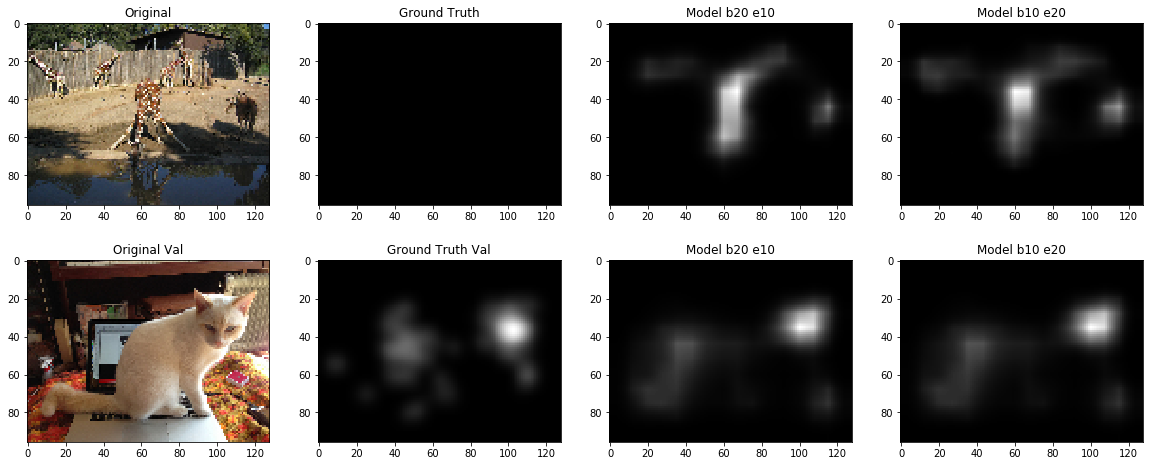

In [13]:
# Testing the different models on a random image from the val set:

test_image_id = randint(0, len(test_data_original['images'])-1)
val_image_id  = randint(0, len(val_data_original['images'])-1)

x,y = test_data.__getitem__(test_image_id)
x_val, y_val = val_data.__getitem__(val_image_id)

original = test_data_original['images'][test_image_id]
original_val = val_data_original['images'][val_image_id]

x = x.contiguous().view(1, *x.size())
x_2 = x[:]
x_val = x_val.contiguous().view(1, *x_val.size())
x_2_val = x_val[:]
if torch.cuda.is_available():
    x = x.cuda()
    x_val = x_val.cuda()
y = y.numpy()
y_val = y_val.numpy()

# model = torch.load('new_model').cuda()
# model.eval()
# model_cnn1.eval()

# First model
x_sal = model(Variable(x))
x_sal_nmp = x_sal.squeeze().data.numpy()

x_val_sal = model(Variable(x_val))
x_val_sal_nmp = x_val_sal.squeeze().data.numpy()

# Second model
x_2_sal = model_2(Variable(x_2))
x_2_sal_nmp = x_2_sal.squeeze().data.numpy()

x_2_val_sal = model(Variable(x_2_val))
x_2_val_sal_nmp = x_2_val_sal.squeeze().data.numpy()

# Plot the output
plt.figure(figsize=(20,8))
plt.subplot(2,4,1); plt.title('Original')
plt.imshow(original)
plt.subplot(2,4,2); plt.title('Ground Truth')
plt.imshow(y, cmap='gray')

plt.subplot(2,4,3)
# plt.imshow(x_sal_nmp1, cmap='gray'); plt.title('CNN+Context+LSTM')
plt.imshow(x_sal_nmp, cmap='gray'); plt.title('Model b20 e10')
# Second model
plt.subplot(2,4,4)
plt.imshow(x_2_sal_nmp, cmap='gray'); plt.title('Model b10 e20')

plt.subplot(2,4,5); plt.title('Original Val')
plt.imshow(original_val)
plt.subplot(2,4,6); plt.title('Ground Truth Val')
plt.imshow(y_val, cmap='gray')

plt.subplot(2,4,7)
plt.imshow(x_val_sal_nmp, cmap='gray'); plt.title('Model b20 e10')
# Second model
plt.subplot(2,4,8)
plt.imshow(x_2_val_sal_nmp, cmap='gray'); plt.title('Model b10 e20')


# plt.subplot(2,4,6)
# plt.imshow(x_sal_nmp2, cmap='gray'); plt.title('Seg.+Context+LSTM')

# plt.subplot(2,4,3)
# plt.imshow(x_sal_nmp3, cmap='gray'); plt.title('CNN+LSTM')
# plt.subplot(2,4,7)
# plt.imshow(x_sal_nmp4, cmap='gray'); plt.title('Seg.+LSTM')

# plt.subplot(2,4,4)
# plt.imshow(x_sal_nmp5, cmap='gray'); plt.title('CNN')

# plt.subplot(2,4,8)
# plt.imshow(x_sal_nmp6, cmap='gray'); plt.title('Seg.')
# plt.savefig('ResExamples/example_'+str(test_image_id)+'.png')
plt.show()

# model.eval()
# x_saln = model(Variable(x))
# x_saln_nmp = x_saln.squeeze().cpu().data.numpy()

# plt.imshow(x_saln_nmp, cmap='gray'); plt.title('new')
# plt.show()

In [ ]:
# Obtaining KLD Loss values on the test set for different models:

loss_fn = nn.KLDivLoss()

# test on validation data, as we don't have ground truths for the test data (this was also done in original DSCLRCN paper)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=5, shuffle=True, num_workers=4)

TestLosses_CNN1 = []
TestLosses_Seg1 = []
TestLosses_CNN2 = []
TestLosses_Seg2 = []
TestLosses_CNN3 = []
TestLosses_Seg3 = []
for i, data in enumerate(test_loader):
    inputs, labels = data
    if torch.cuda.is_available():
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs = Variable(inputs)
        lables = Variable(labels)
    
    #test_outputs_CNN1 = model_cnn1(inputs).squeeze()
    test_outputs_Seg1 = model(inputs).squeeze()
    
    #test_outputs_CNN2 = model_cnn2(inputs).squeeze()
    test_outputs_Seg2 = model_2(inputs).squeeze()
    
    #test_outputs_CNN3 = model_cnn3(inputs).squeeze()
    #test_outputs_Seg3 = model_seg3(inputs).squeeze()
    
    labels_sum = torch.sum(labels.contiguous().view(labels.size(0),-1), dim=1)
    labels /= labels_sum.contiguous().view(*labels_sum.size(), 1, 1).expand_as(labels)

    #TestLosses_CNN1.append(loss_fn(torch.log(test_outputs_CNN1), labels).data[0])
    TestLosses_Seg1.append(loss_fn(torch.log(test_outputs_Seg1), labels).data[0])
    
    #TestLosses_CNN2.append(loss_fn(torch.log(test_outputs_CNN2), labels).data[0])
    TestLosses_Seg2.append(loss_fn(torch.log(test_outputs_Seg2), labels).data[0])
    
    #TestLosses_CNN3.append(loss_fn(torch.log(test_outputs_CNN3), labels).data[0])
    #TestLosses_Seg3.append(loss_fn(torch.log(test_outputs_Seg3), labels).data[0])

#print('TestLoss (CNN): ', np.mean(TestLosses_CNN1), np.mean(TestLosses_CNN2), np.mean(TestLosses_CNN3))
print('TestLoss (Seg): ', np.mean(TestLosses_Seg1), np.mean(TestLosses_Seg2))#, np.mean(TestLosses_Seg3))